#   
<span style="font-family:Arial; font-weight:Bold; font-size:2.3em; color:#00b3e5;"> Text Summarizer

#####      
<span style="font-family:Arial; font-weight:Bold; font-size:1.8em; color:#00b3e5;"> loading libraries  

In [1]:
import numpy  as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt

import re #, string, unicodedata
#from   bs4 import BeautifulSoup

#from   textblob  import TextBlob, Word
from   wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
#import spacy

#from sklearn.svm           import SVC
#from sklearn.naive_bayes   import MultinomialNB
#from sklearn.preprocessing import LabelBinarizer
from sklearn.linear_model  import LogisticRegression, SGDClassifier
from sklearn               import model_selection, preprocessing, naive_bayes, ensemble 
from sklearn.decomposition import NMF, LatentDirichletAllocation, TruncatedSVD
from sklearn.metrics       import classification_report, confusion_matrix, accuracy_score
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

In [2]:
import nltk   # pip install --upgrade nltk

nltk.download('punkt')
from nltk.probability      import FreqDist
#from nltk.tokenize.toktok import ToktokTokenizer
from nltk.tokenize         import word_tokenize, sent_tokenize

nltk.download('stopwords') 
from nltk.corpus           import stopwords

nltk.download('wordnet')
from nltk.stem             import WordNetLemmatizer 

#from nltk.stem            import LancasterStemmer 
#from nltk.stem.porter     import PorterStemmer

[nltk_data] Downloading package punkt to C:\Users\EZ-
[nltk_data]     Tech\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to C:\Users\EZ-
[nltk_data]     Tech\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to C:\Users\EZ-
[nltk_data]     Tech\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


#####      
<span style="font-family:Arial; font-weight:Bold; font-size:1.8em; color:deeppink;"> loading dataset

In [26]:
with open('Story_2.txt', 'r') as file:
    text = file.read().strip().replace('\n',' ').replace(';','.').replace('-',' ')
    
Clean_Text = ''
for word in word_tokenize(text):
    Clean_Text = Clean_Text + ' ' + word
text = Clean_Text

text

" THE FIVE ORANGE PIPS . Arthur Conan Doyle . When I glance over my notes and records of the Sherlock Holmes cases between the years '82 and '90 , I am faced by so many which present strange and interesting features that it is no easy matter to know which to choose and which to leave . Some , however , have already gained publicity through the papers , and others have not offered a field for those peculiar qualities which my friend possessed in so high a degree , and which it is the object of these papers to illustrate . Some , too , have baffled his analytical skill , and would be , as narratives , beginnings without an ending , while others have been but partially cleared up , and have their explanations founded rather upon conjecture and surmise than on that absolute logical proof which was so dear to him . There is , however , one of these last which was so remarkable in its details and so startling in its results that I am tempted to give some account of it in spite of the fact th

In [27]:
data = pd.DataFrame( )
data['text'] = [text]
data.head()

,text
0,THE FIVE ORANGE PIPS . Arthur Conan Doyle . W...


#####      
<span style="font-family:Arial; font-weight:Bold; font-size:1.8em; color:#00b3e5;"> NLP Preprocessing

<span style="font-family:Arial; font-weight:Bold; font-size:1.5em; color:#00b3e5;"> Remove New Lines

In [28]:
# removing new lines
def remove_new_lines(text): return re.sub('[\n]',' ', text)
data['text'] = data['text'].apply(remove_new_lines)

<span style="font-family:Arial; font-weight:Bold; font-size:1.5em; color:#00b3e5;"> Remove Punctuations

In [29]:
# removing punctuations
def remove_punctuations(text): return re.sub('[^a-zA-Z]',' ', text)
data['text'] = data['text'].apply(remove_punctuations)

<span style="font-family:Arial; font-weight:Bold; font-size:1.5em; color:#00b3e5;"> Converting to LowerCase

In [30]:
# converting text to lower_case
def into_lower(text): return text.lower()
data['text'] = data['text'].apply(into_lower)

<span style="font-family:Arial; font-weight:Bold; font-size:1.5em; color:#00b3e5;"> Set & Remove Stop_Words

<span style="font-family:Arial; font-weight:Bold; font-size:1.2em; color:#00b3e5;"> Setting Stop_Words

In [31]:
# Setting English StopWords
stop_words = set( stopwords.words('english') )
new_words  = [ 'some','like' ,'br', 'could','would','get','make','really','see',
               'well','much','good','great','first','last','people','also','bad','worst' ,'may','thing',
               'make','go','think','know','watch','look','many','said','say','mr','new','take','told','back',
               'upon', 'yes', 'no', 'u', 's', 'k', 'n', 'next', 'half', 'quarter', 'third', 
               'late', 'ago', 'before', 'after', 'behind', 'back', 'front', 'oh', 'yet', 'indeed', 'due',
               'give', 'find', 'come', 'seem', 'whether', 'if'
             ] 
stop_words = stop_words.union(new_words)

<span style="font-family:Arial; font-weight:Bold; font-size:1.2em; color:#00b3e5;"> Removing Stop_Words

In [32]:
def remove_stop_words(text):
    Clean = []
    for word in text.split():
        if word.strip() not in stop_words:
            Clean.append(word.strip()) 
    return ' '.join( Clean )

data['text'] = data['text'].apply( remove_stop_words )
data['text'][0][:300]

'five orange pips arthur conan doyle glance notes records sherlock holmes cases years faced present strange interesting features easy matter choose leave however already gained publicity papers others offered field peculiar qualities friend possessed high degree object papers illustrate baffled analy'

<span style="font-family:Arial; font-weight:Bold; font-size:1.5em; color:#00b3e5;"> Lemmatizing

In [33]:
# Lemmatizing 
lemmatizer = WordNetLemmatizer()

def lemmatize_text(text):
    Clean = []
    for word in text.split():
        w = word
        w = lemmatizer.lemmatize(w, pos="n")   # nouns
        w = lemmatizer.lemmatize(w, pos="v")   # verbs
        w = lemmatizer.lemmatize(w, pos="a")   # adj
        w = lemmatizer.lemmatize(w, pos="r")   # adv
        w = lemmatizer.lemmatize(w, pos="s")   # satellite adj
        Clean.append( w )
    return ' '.join( Clean )

data['text'] = data['text'].apply(lemmatize_text)
data['text'][0][:300]

'five orange pip arthur conan doyle glance note record sherlock holmes case year face present strange interest feature easy matter choose leave however already gain publicity paper others offer field peculiar quality friend possess high degree object paper illustrate baffle analytical skill narrative'

<span style="font-family:Arial; font-weight:Bold; font-size:1.5em; color:#00b3e5;"> Stemming
 - Faster but less accurate than Lemmatizer

In [34]:
# Stemming
''' 
Stemmer = PorterStemmer()

def stem_text(text):
    Clean = []
    for word in text.split():
        Clean.append( Stemmer.stem(word) )
    return ' '.join( Clean )

data['text'] = data['text'].apply(stem_text)
data.head()
''' 
pass

<span style="font-family:Arial; font-weight:Bold; font-size:1.2em; color:#00b3e5;"> Removing Stop_Words

In [35]:
data['text'] = data['text'].apply( remove_stop_words )
data['text'][0][:300]

'five orange pip arthur conan doyle glance note record sherlock holmes case year face present strange interest feature easy matter choose leave however already gain publicity paper others offer field peculiar quality friend possess high degree object paper illustrate baffle analytical skill narrative'

<span style="font-family:Arial; font-weight:Bold; font-size:1.5em; color:#00b3e5;"> Bag of Words (List)

In [36]:
def bag_of_words_maker(df,ft):
    texts = df[ft]
    bag   = []
    for text in texts:
        for word in text.split():
            bag.append( word )
    return bag

bag_of_words = bag_of_words_maker( data, 'text' )
bag_of_words[:5]

['five', 'orange', 'pip', 'arthur', 'conan']

<span style="font-family:Arial; font-weight:Bold; font-size:1.5em; color:#00b3e5;"> Bag of Words (DataFrame)

In [37]:
bag_of_words = pd.DataFrame( bag_of_words, columns=['word'] )
bag_of_words.head(5)

,word
0,five
1,orange
2,pip
3,arthur
4,conan


<span style="font-family:Arial; font-weight:Bold; font-size:1.5em; color:#00b3e5;"> Words Count (DataFrame)

In [38]:
words_count         = pd.DataFrame( bag_of_words[ 'word' ].value_counts() )
words_count['word'] = words_count.index
words_count.index   = range( words_count.shape[0] )
words_count.head(15)

,count,word
0,30,one
1,26,paper
2,25,holmes
3,21,day
4,20,man
5,20,time
6,18,must
7,18,letter
8,16,shall
9,16,however


<span style="font-family:Arial; font-weight:Bold; font-size:1.5em; color:#00b3e5;"> Visualizing Top Words

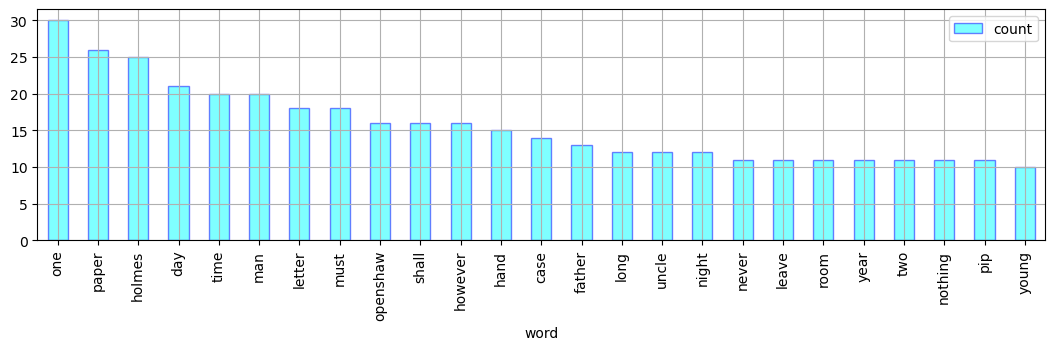

In [39]:
df = words_count
cat, sclr = 'word', 'count'

df.groupby(by=[cat])[sclr].median().reset_index().sort_values([sclr],ascending=False).head(25).\
plot( x=cat, y=sclr, kind='bar',  figsize=(13,3), color='cyan', edgecolor='blue', alpha=0.5, grid='on' ); plt.show()

<span style="font-family:Arial; font-weight:Bold; font-size:1.8em; color:deeppink;"> Keeping Top Words

In [40]:
n = 3000
Top_Words = words_count.loc[:n,'word'].tolist()
Top_Words[:5]

['one', 'paper', 'holmes', 'day', 'man']

<span style="font-family:Arial; font-weight:Bold; font-size:1.8em; color:#00b3e5;"> Text Reduction

In [41]:
def text_reduct( text ):
    Clean = []
    for word in text.split():
        if word in Top_Words:
            Clean.append(word)
    return ' '.join(Clean)

data['text'] = data['text'].apply(text_reduct)
#data['text'][0]

#####      
<span style="font-family:Arial; font-weight:Bold; font-size:1.8em; color:#00b3e5;"> Cool Image of Top Phrases

In [42]:
df = pd.DataFrame( )
df['text'] = [text]
df['text'] = df['text'].apply(remove_new_lines)
#df['text'] = df['text'].apply(remove_punctuations)
df['text'] = df['text'].apply(into_lower)

vec=CountVectorizer( min_df=0, max_df=500, binary=False, ngram_range=(2,3) ).fit( df['text'] )
bag=vec.transform(data['text'])

s = bag.sum(axis=0)
f = [ (word,s[0,idx]) for word, idx in vec.vocabulary_.items() ]
f = sorted( f, key=lambda x: x[1], reverse=True )
f[:50]

[('sherlock holmes', 10),
 ('lone star', 6),
 ('john openshaw', 5),
 ('young man', 4),
 ('brass box', 4),
 ('young openshaw', 4),
 ('must put', 3),
 ('baker street', 2),
 ('major prendergast', 2),
 ('near horsham', 2),
 ('lumber room', 2),
 ('five little', 2),
 ('breakfast table', 2),
 ('one hand', 2),
 ('colonel openshaw', 2),
 ('uncle life', 2),
 ('practical joke', 2),
 ('chalk pit', 2),
 ('john swain', 2),
 ('shall set', 2),
 ('save perhaps', 2),
 ('mail boat', 2),
 ('ku klux', 2),
 ('klux klan', 2),
 ('near waterloo', 2),
 ('waterloo bridge', 2),
 ('barque lone', 2),
 ('star savannah', 2),
 ('ku klux klan', 2),
 ('near waterloo bridge', 2),
 ('barque lone star', 2),
 ('lone star savannah', 2),
 ('five orange', 1),
 ('arthur conan', 1),
 ('conan doyle', 1),
 ('present strange', 1),
 ('easy matter', 1),
 ('high degree', 1),
 ('analytical skill', 1),
 ('absolute logical', 1),
 ('logical proof', 1),
 ('however one', 1),
 ('probably never', 1),
 ('long series', 1),
 ('less interest', 1)

In [43]:
Top_N = 7
Top_Phrases = pd.DataFrame(f[:Top_N], columns=['Word','Freq'])
Freq_Max = Top_Phrases.loc[0,'Freq']
Top_Phrases.head()

,Word,Freq
0,sherlock holmes,10
1,lone star,6
2,john openshaw,5
3,young man,4
4,brass box,4


In [44]:
Top_Corpus = []
for w in Top_Phrases['Word']:
    try:
        w1,w2,w3,w4 = w.split()
        Top_Corpus.append(str(w1+'_'+w2+'_'+w3+'_'+w4))
    except:
        try:
            w1,w2,w3 = w.split()
            Top_Corpus.append(str(w1+'_'+w2+'_'+w3))
        except:
            try:
                w1,w2 = w.split()
                Top_Corpus.append(str(w1+'_'+w2))
            except:
                Top_Corpus.append(str(w))
Top_Corpus = ' '.join(Top_Corpus)
Top_Corpus

'sherlock_holmes lone_star john_openshaw young_man brass_box young_openshaw must_put'

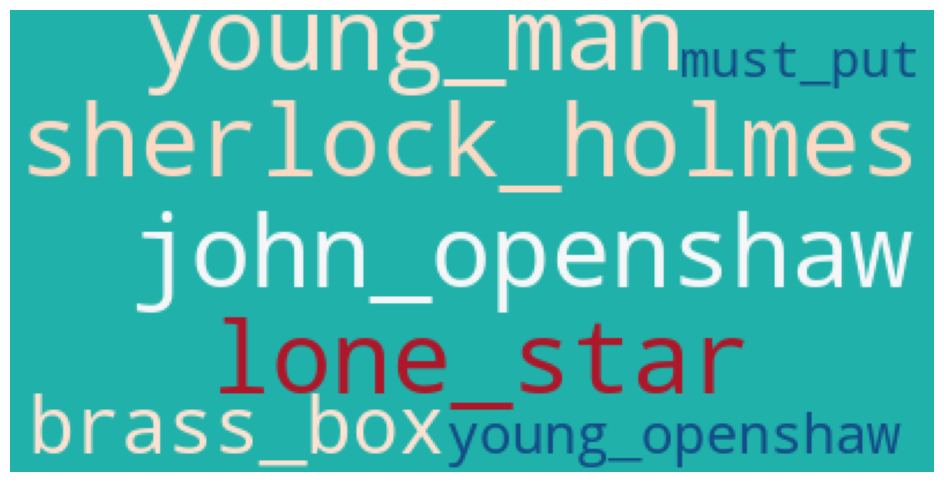

In [45]:
wordcloud = WordCloud( 
    
    background_color='LightSeaGreen', colormap='RdBu',
    #background_color='black', colormap='Greens',
    #background_color='black', colormap='Blues',
    
    stopwords        = stop_words,
    max_words        = Top_N,
    max_font_size    = 50,
    random_state     = 7 
    ).generate( str(Top_Corpus) ) 

fig = plt.figure(figsize=(13,6))
plt.imshow(wordcloud)
plt.axis('off')
plt.show()

#####   

<span style="font-family:Arial; font-weight:Bold; font-size:1.8em; color:deeppink;"> TOP WORDS

In [46]:
# input
MIN_Repeat = 2   # minimum number of appearances in text

# auto
TOP_WORDS = []
for w in f:
    if w[1] >= MIN_Repeat:
        try:
            w1,w2,w3 = w[0].split( )
            TOP_WORDS.append( w1 )
            TOP_WORDS.append( w2 )
            TOP_WORDS.append( w3 )
        except:
            w1,w2 = w[0].split( )
            TOP_WORDS.append( w1 )
            TOP_WORDS.append( w2 )            
TOP_WORDS = list( set( TOP_WORDS ))
TOP_WORDS.sort()
TOP_WORDS

['baker',
 'barque',
 'boat',
 'box',
 'brass',
 'breakfast',
 'bridge',
 'chalk',
 'colonel',
 'five',
 'hand',
 'holmes',
 'horsham',
 'john',
 'joke',
 'klan',
 'klux',
 'ku',
 'life',
 'little',
 'lone',
 'lumber',
 'mail',
 'major',
 'man',
 'must',
 'near',
 'one',
 'openshaw',
 'perhaps',
 'pit',
 'practical',
 'prendergast',
 'put',
 'room',
 'savannah',
 'save',
 'set',
 'shall',
 'sherlock',
 'star',
 'street',
 'swain',
 'table',
 'uncle',
 'waterloo',
 'young']

#####   

In [47]:
MIN_REP = 30

for i in words_count.index:
    if words_count.loc[i,'count']>= MIN_REP:
        w = words_count.loc[i,'word'] 
        TOP_WORDS.append( w )           
TOP_WORDS = list( set( TOP_WORDS ))
TOP_WORDS.sort()
TOP_WORDS

['baker',
 'barque',
 'boat',
 'box',
 'brass',
 'breakfast',
 'bridge',
 'chalk',
 'colonel',
 'five',
 'hand',
 'holmes',
 'horsham',
 'john',
 'joke',
 'klan',
 'klux',
 'ku',
 'life',
 'little',
 'lone',
 'lumber',
 'mail',
 'major',
 'man',
 'must',
 'near',
 'one',
 'openshaw',
 'perhaps',
 'pit',
 'practical',
 'prendergast',
 'put',
 'room',
 'savannah',
 'save',
 'set',
 'shall',
 'sherlock',
 'star',
 'street',
 'swain',
 'table',
 'uncle',
 'waterloo',
 'young']

#####   

#####      
<span style="font-family:Arial; font-weight:Bold; font-size:1.8em; color:#00b3e5;"> Summary

In [50]:
# input
num_sentences = 25

# Calculate word frequencies
fdist = FreqDist( TOP_WORDS )

for i in words_count.index:
    w = words_count.loc[ i, 'word' ]
    if w in TOP_WORDS:
        freq = words_count.loc[ i, 'count' ]
        freq = min( Freq_Max, freq )
        fdist[ w ] = freq

# Assign scores to sentences based on word frequencies
sentences       = sent_tokenize( text )
sentence_scores = [ sum(fdist[word] for word in word_tokenize(
    lemmatizer.lemmatize( 
        lemmatizer.lemmatize( 
            lemmatizer.lemmatize( 
                lemmatizer.lemmatize( 
                    lemmatizer.lemmatize( sentence.lower()
                                        , pos="n" ), pos="v" ), pos="a" ), pos="r" ), pos="s" )
) if word in fdist) for sentence in sentences]


# Create a list of tuples containing sentence index and score
sentence_scores = list(enumerate(sentence_scores))

# Sort sentences by scores in descending order
sorted_sentences = sorted(sentence_scores, key=lambda x: x[1], reverse=True)

# Choosing top `num_sentences` sentences for the summary
chosen_sentences = sorted_sentences[:num_sentences]

# Sort the randomly selected sentences based on their original order in the text
summary_sentences = sorted(chosen_sentences, key=lambda x: x[0])

# Create the summary
summary = '/     ...     /'.join([sentences[i] for i, _ in summary_sentences])
summary

"In the latter , as may be remembered , Sherlock Holmes was able , by winding up the dead man 's watch , to prove that it had been wound up two hours before , and that therefore the deceased had gone to bed within that time a deduction which was of the greatest importance in clearing up the case ./     ...     /Sherlock Holmes sat moodily at one side of the fireplace cross indexing his records of crime , while I at the other was deep in one of Clark Russell 's fine sea stories until the howl of the gale from without seemed to blend with the text , and the splash of the rain to lengthen out into the long swash of the sea waves ./     ...     /`` My name , '' said he , `` is John Openshaw , but my own affairs have , as far as I can understand , little to do with this awful business ./     ...     /`` My uncle Elias emigrated to America when he was a young man and became a planter in Florida , where he was reported to have done very well ./     ...     /There was one singular exception , 

#####   

#####   